# Лабораторная 4 (Вариант 3)
Здесь отображены по большей части вычисления, более подробно я расписал на бумаге в `notes/*.jpg`.
Есть данные о мобильных телефонах (`data/mobile_phones.csv`).

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.display import display, Markdown

def get_verdict(pl, alpha=0.05):
    '''
    :param pl: p-value the test returned
    :param alpha: statistical significance
    :return: human-readable verdict
    '''
    if pl > alpha:
        return rf'$H_0$ is accepted ($\alpha={alpha}$)'
    else:
        return rf'$H_0$ is rejected in favor of $H_1$ ($\alpha={alpha}$)'

df = pd.read_csv('data/mobile_phones.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


## Задание 1
### Постановка задачи
Разумно ли считать, что емкость аккумулятора распределена равномерно?

### Решение
Здесь нужно сформулировать гипотезу о виде распределения.
На лекциях для проверки таких гипотез мы ввели два критерия: Колмогорова-Смирнова и критерий согласия Пирсона (Хи-квадрат).

В этой задаче считаем, что емкость аккумулятора имеет непрерывное распределение
(это нужно для работы критерия Колмогорова-Смирнова).

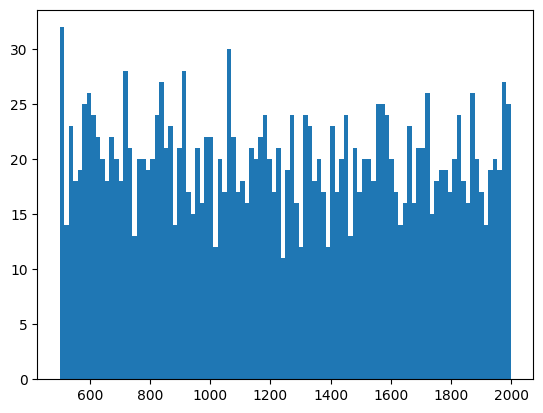

In [118]:
# Посмотрим на то, как выглядит распределение

x = df['battery_power'].to_numpy()

plt.hist(x, bins=100)
plt.show()

#### Критерий Колмогорова
Составим гипотезы:
- $H_0$: $X=\operatorname{battery\_power}$ имеет распределение $U[\tilde{\theta}_1,\tilde{\theta}_2]$
- $H_1$: $X$ имеет другое распределение
Здесь $\tilde{\theta}_i$ - это ОМП.
Найдём ОМП для нашего датасета:

In [100]:
# Проведём one-sample K-S test:

# ОМП для параметров распределения:
theta1 = x.min()
theta2 = x.max()
alpha = 0.05

null_cdf = lambda x: stats.uniform.cdf(x, loc=theta1, scale=theta2-theta1)

kstest_result = stats.ks_1samp(x, null_cdf)
s = kstest_result.statistic
pl = kstest_result.pvalue

display(Markdown(f'''
Result of one-sample K-S test: $\sqrt{{n}}D_n={s:.3}$ $\operatorname{{pvalue}}={pl:.3}$
{get_verdict(pl, alpha)}
'''))


Result of one-sample K-S test: $\sqrt{n}D_n=0.0208$ $\operatorname{pvalue}=0.349$
$H_0$ is accepted ($\alpha=0.05$)


#### Критерий согласия Пирсона (Хи-Квадрат)
Здесь мы с помощью `pyplot.hist` сделаем разбиение на отрезки, таким образом
все они будут иметь одинаковую длину и нам будет легче сформулировать нулевую
гипотезу, а именно: если бы распределение было равномерным, то в каждом отрезке
были бы примерно одни и те же частоты. Т.е. имеем такую нулевую гипотезу:
- $H_0$: $p=p_0=(\frac{1}{m},\ldots,\frac{1}{m})$
- $H_1$: $p \neq p_0$



Result of Chi-square test: $\chi_m^2=83.7$ $\operatorname{pvalue}=0.865$
$H_0$ is accepted ($\alpha=0.05$)


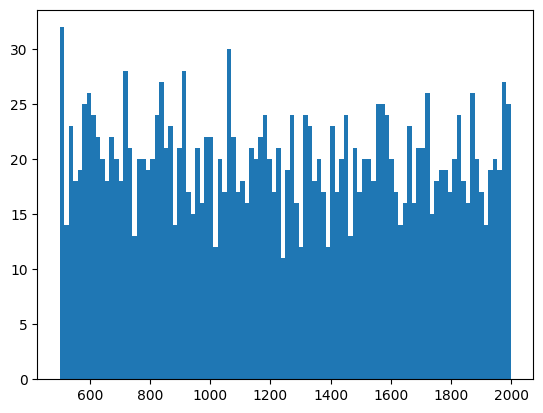

In [112]:
freqs, bin_edges, _ = plt.hist(x, bins=100)
# Все частоты должны быть ненулевыми
assert (freqs > 0).all()
# Более того, на лекции рекомендовалось, чтобы все частоты были не меньше 5
assert (freqs >= 5).all()

chisquare_result = stats.chisquare(freqs)

s = chisquare_result.statistic
pl = chisquare_result.pvalue

display(Markdown(f'''
Result of Chi-square test: $\chi_m^2={s:.3}$ $\operatorname{{pvalue}}={pl:.3}$
{get_verdict(pl, alpha)}
'''))

## Задание 2
Здесь на каждый из вопросов нужно один тест.
### Вопрос 1
Верно ли, что телефонов с поддержкой 3G больше моделей с Wi-Fi?
Уточнение: "верно ли, что вероятность наличия у телефона поддержки 3G больше вероятности?"

### Решение
Здесь будет удобно воспользоваться Z-test ("Зет квадрат"), т.к. он позволяет удобно настроить альтернативную гипотезу.
Пусть $p_1$ - вероятность модели телефона иметь 3G, $p_2$ - вероятность иметь Wifi.
Тогда:
- $H_0$: $p_1=p_2$
- $H_1$: $p_1>p_2$
Статистика: $$Z_{n_1n_2}=
\left(
    \frac{\nu_{11}}{n_1}-\frac{\nu_{21}}{n_2}
\right)
\sqrt{
    \frac{n n_1 n_2}{\nu_{*1} \nu_{*2}}
}$$
В данном случае очень важна область принятия нулевой гипотезы: $T_0(\alpha)=(-\infty,q_{1-\alpha})$
Понятно, что здесь квантиль от стандартного нормального закона, т.к. $Z_{n_1n_2} \xrightarrow[n_1,n_2\rightarrow\infty]{} Y \sim N(0,1)$

In [134]:
def calc_z(a, b):
    n1 = len(a)
    n2 = len(a)

    nu11 = a.sum()
    nu12 = n1 - nu11
    nu21 = b.sum()
    nu22 = n2 - nu21

    z = (nu11/n1 - nu21/n2)*((n1 + n2) * n1 * n2 / ((nu11 + nu21)*(nu12 + nu22)))**0.5
    return z

x3g = df['three_g']
xwifi = df['wifi']

alpha = 0.05

if calc_z(x3g, xwifi) < stats.norm.ppf(1-alpha):
    display(Markdown(rf'$H_0$ is accepted ($\alpha={alpha}$)'))
else:
    display(Markdown(rf'$H_0$ is rejected in favor of $H_1$ ($\alpha={alpha}$)'))

$H_0$ is rejected in favor of $H_1$ ($\alpha=0.05$)

### Вопрос 2
Разнится ли количество телефонов с touch screen от моделей с двумя сим-картами?
Уточнение: "верно ли, что вероятность иметь touch screen не равна вероятности иметь две симкарты?"

### Решение
Здесь делаем абсолютно то же самое, что и в вопросе 1, но здесь в качестве альтернативы выступает утверждение $p_1 \neq p_2$.
Соответственно, здесь другая область принятия.
- $H_0$: $p_1=p_2$
- $H_1$: $p_1 \neq p_2$
Статистика: ditto 2.1
Область принятия нулевой гипотезы: $T_0(\alpha)=(-q_{1-\alpha},q_{1-\alpha})$
Понятно, что здесь квантиль от стандартного нормального закона, т.к. $Z_{n_1n_2} \xrightarrow[n_1,n_2\rightarrow\infty]{} Y \sim N(0,1)$


In [135]:
xtouch = df['touch_screen']
xsim = df['dual_sim']

alpha = 0.05

q = stats.norm.ppf(1-alpha)
if -q < calc_z(xtouch, xsim) < q:
    display(Markdown(rf'$H_0$ is accepted ($\alpha={alpha}$)'))
else:
    display(Markdown(rf'$H_0$ is rejected in favor of $H_1$ ($\alpha={alpha}$)'))

$H_0$ is accepted ($\alpha=0.05$)

## Задание 3
### Постановка задачи
Есть подозрение, что цена зависит от объема оперативной памяти.
Проверите данное утверждение.

### Решение
Здесь нужно сформулировать гипотезу о зависимости одной выборки от другой.
В нашем случае объёмы выборок совпадают.
Я выбрал такие критерии для проверки на зависимость: критерий Спирмана и Хи-квадрат.

#### Критерий Спирмана
- $H_0$: выборки независимы
- $H_1$: $\neg H_0$
Здесь статистика - $\sqrt{n}\cdot \rho$, где $\rho$ - коэффициент корреляции Спирмана.
Причем для статистики известно, что $\sqrt{n}\cdot \rho \xrightarrow[n\rightarrow\infty]{} Y \sim N(0,1)$
Здесь уже можно принимать/опровергать гипоетзу на основании p-value.

In [147]:
xprice = df['price_range']
xmem = df['int_memory']

rho, pval = stats.spearmanr(xprice, xmem)

alpha = 0.05

display(Markdown(get_verdict(pval, alpha)))

$H_0$ is rejected in favor of $H_1$ ($\alpha=0.05$)

#### Хи-квадрат
Здесь немного расписано т.к. я воспользовался встроенными инструментами для построения таблицы сопряженности и расчёта статистики/pvalue.
- $H_0$: выборки независимы
- $H_1$: $\neg H_0$

In [148]:
# На цены и память нам не надо смотреть, просто распаковал для наглядности, что делает `crosstab`
(prices, mems), contingency_table = stats.contingency.crosstab(xprice, xmem)

chi2, pvalue, dof, ex = stats.chi2_contingency(contingency_table)

# Проверим, что степеней свободы нужное количество
assert dof == (len(prices) - 1)*(len(mems) - 1)

display(Markdown(get_verdict(pvalue, alpha)))

$H_0$ is accepted ($\alpha=0.05$)